In [18]:
import numpy as np
import copy
from matplotlib import pyplot as plt

ROWS = 3
COLS = 4
WIN = (0, 3)
LOSE = (1, 3)
START = (2, 0)
all_Q = []
determine = True

class Environment:
    def __init__(self, state=START):
        self.board = np.zeros([ROWS, COLS])
        self.board[1, 1] = -1
        self.state = state
        self.isEnd = False
        self.determine = determine

        
    def giveReward(self):
        if self.state == WIN:
            return 1
        elif self.state == LOSE:
            return -1
        else:
            return -0.04

        
    def isEndFunc(self):
        if (self.state == WIN) or (self.state == LOSE):
            self.isEnd = True

            
    def chooseActionProb(self, action):
        if action == "up":
            return np.random.choice(["up", "left", "right"], p=[0.8, 0.1, 0.1])
        if action == "down":
            return np.random.choice(["down", "left", "right"], p=[0.8, 0.1, 0.1])
        if action == "left":
            return np.random.choice(["left", "up", "down"], p=[0.8, 0.1, 0.1])
        if action == "right":
            return np.random.choice(["right", "up", "down"], p=[0.8, 0.1, 0.1])

        
    def nextPosition(self, action):
        if self.determine:
            if action == "up":
                next_state = (self.state[0] - 1, self.state[1])
            elif action == "down":
                next_state = (self.state[0] + 1, self.state[1])
            elif action == "left":
                next_state = (self.state[0], self.state[1] - 1)
            else:
                next_state = (self.state[0], self.state[1] + 1)
            self.determine = False
        else:
            action = self.chooseActionProb(action)
            self.determine = True
            next_state = self.nextPosition(action)

        if (next_state[0] >= 0) and (next_state[0] <= 2):
            if (next_state[1] >= 0) and (next_state[1] <= 3):
                if next_state != (1, 1):
                    return next_state
        return self.state

    
    def showBoard(self):
        self.board[self.state] = 1
        for i in range(0, ROWS):
            print('-----------------')
            out = '| '
            for j in range(0, COLS):
                if self.board[i, j] == 1:
                    token = '*'
                if self.board[i, j] == -1:
                    token = '#'
                if self.board[i, j] == 0:
                    token = '0'
                out += token + ' | '
            print(out)
        print('-----------------')


class Agent:

    def __init__(self):
        self.states = []
        self.actions = ["up", "down", "left", "right"]
        self.Environment = Environment()
        self.isEnd = self.Environment.isEnd
        self.lr = 0.2
        self.epsilon = 0.3
        self.gamma = 0.9
        self.counter = 0

        self.Q_values = {}
        for i in range(ROWS):
            for j in range(COLS):
                self.Q_values[(i, j)] = {}
                for a in self.actions:
                    self.Q_values[(i, j)][a] = 0
        
        self.state_values = {}
        for i in range(ROWS):
            for j in range(COLS):
                self.state_values[(i, j)] = 0  
    
    
    def chooseAction(self, adaptive_epsilon=False):
        max_next_reward = 0
        action = ""
        
        if adaptive_epsilon:
            self.epsilon = 100/(200+self.counter*2)
        #print(self.epsilon)
        if np.random.uniform(0, 1) <= self.epsilon:
            action = np.random.choice(self.actions)
        else:
            if not self.Environment.determine:
                for a in self.actions:
                    current_position = self.Environment.state
                    next_reward = self.Q_values[current_position][a]
                    if next_reward >= max_next_reward:
                        action = a
                        max_next_reward = next_reward
            else:        
                for a in self.actions:
                    next_reward = self.state_values[self.Environment.nextPosition(a)]
                    if next_reward >= max_next_reward:
                        action = a
                        max_next_reward = next_reward
        return action

    
    def takeAction(self, action):
        position = self.Environment.nextPosition(action)
        return Environment(state=position)

    
    def reset(self):
        self.states = []
        self.Environment = Environment()
        self.isEnd = self.Environment.isEnd
        
        
    def Q_learning(self, iterations=10, adaptive_lr=False, adaptive_epsilon=False):
        i = 0
        while i < iterations:
            if self.Environment.isEnd:
                reward = self.Environment.giveReward()
                for a in self.actions:
                    self.Q_values[self.Environment.state][a] = reward
                print("Terminalno stanje! Nagrada iznosi:", reward)
                help_bool = True
                for s in reversed(self.states):
                    if s[0] in self.Q_values.keys():
                        for j in self.Q_values.keys():
                            if not s[1] in self.Q_values[j]:
                                help_bool = False
                        if help_bool:
                            current_q_value = self.Q_values[s[0]][s[1]]
                        else:
                            current_q_value = 0
   
                    if adaptive_lr:
                        self.lr = np.log(self.counter + 1)/(self.counter + 1)
                        
                    reward = current_q_value + self.lr * (self.gamma * reward - current_q_value)
                    self.Q_values[s[0]][s[1]] = round(reward, 3)
                #print(self.Q_values)
                all_Q.append(copy.deepcopy(self.Q_values))
                self.reset()
                self.counter = 0
                i += 1
            else:
                action = self.chooseAction(adaptive_epsilon)
                self.states.append([(self.Environment.state), action])
                self.Environment = self.takeAction(action)
                print("Trenutna pozicija: {}    Akcija: {}".format(self.Environment.state, action))
                self.Environment.showBoard()
                self.Environment.isEndFunc()
                self.counter += 1
                self.isEnd = self.Environment.isEnd
        

    def valueIteration(self, rounds=10):
        i = 0
        while i < rounds:
            if self.Environment.isEnd:
                reward = self.Environment.giveReward()
                self.state_values[self.Environment.state] = reward 
                print("Terminalno stanje! Nagrada iznosi:", reward)
                #self.showValues()
                for s in reversed(self.states):
                    reward = self.state_values[s] + self.lr * (self.gamma*reward - self.state_values[s])
                    self.state_values[s] = round(reward, 3)
                self.reset()
                i += 1
            else:
                action = self.chooseAction()
                self.states.append(self.Environment.nextPosition(action))
                print("Trenutna pozicija: {}    Akcija: {}".format(self.Environment.state, action))
                self.Environment = self.takeAction(action)
                self.Environment.isEndFunc()
                

    def showValues(self):
        for i in range(0, ROWS):
            print('----------------------------------')
            out = '| '
            for j in range(0, COLS):
                out += str(self.state_values[(i, j)]).ljust(6) + ' | '
            print(out)
        print('----------------------------------')
        
        
if __name__ == "__main__":
    
    ag = Agent()
    
    iterations = 100
    print("Q - Learing")
    ag.Q_learning(iterations)
    print(ag.Q_values)
    
    print("Value iteration")
    ag.valueIteration(iterations)
    ag.showValues()


Q - Learing
Trenutna pozicija: (2, 0)    Akcija: right
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | # | 0 | 0 | 
-----------------
| * | 0 | 0 | 0 | 
-----------------
Trenutna pozicija: (2, 1)    Akcija: right
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | # | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
Trenutna pozicija: (2, 2)    Akcija: right
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | # | 0 | 0 | 
-----------------
| 0 | 0 | * | 0 | 
-----------------
Trenutna pozicija: (2, 3)    Akcija: right
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | # | 0 | 0 | 
-----------------
| 0 | 0 | 0 | * | 
-----------------
Trenutna pozicija: (2, 3)    Akcija: right
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | # | 0 | 0 | 
-----------------
| 0 | 0 | 0 | * | 
-----------------
Trenutna pozicija: (2, 3)    Akcija: right
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | # | 0 | 0 | 
-----------

-----------------
| 0 | # | 0 | 0 | 
-----------------
| 0 | 0 | 0 | * | 
-----------------
Trenutna pozicija: (1, 3)    Akcija: right
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | # | 0 | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
Terminalno stanje! Nagrada iznosi: -1
Trenutna pozicija: (1, 0)    Akcija: right
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| * | # | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
Trenutna pozicija: (1, 0)    Akcija: right
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| * | # | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
Trenutna pozicija: (0, 0)    Akcija: right
-----------------
| * | 0 | 0 | 0 | 
-----------------
| 0 | # | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
Trenutna pozicija: (0, 1)    Akcija: right
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | # | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
Trenutna p

Trenutna pozicija: (2, 2)    Akcija: right
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | # | 0 | 0 | 
-----------------
| 0 | 0 | * | 0 | 
-----------------
Trenutna pozicija: (2, 2)    Akcija: right
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | # | 0 | 0 | 
-----------------
| 0 | 0 | * | 0 | 
-----------------
Trenutna pozicija: (2, 3)    Akcija: right
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | # | 0 | 0 | 
-----------------
| 0 | 0 | 0 | * | 
-----------------
Trenutna pozicija: (2, 3)    Akcija: down
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | # | 0 | 0 | 
-----------------
| 0 | 0 | 0 | * | 
-----------------
Trenutna pozicija: (1, 3)    Akcija: right
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | # | 0 | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
Terminalno stanje! Nagrada iznosi: -1
Trenutna pozicija: (2, 1)    Akcija: right
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 |

-----------------
| 0 | # | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
Trenutna pozicija: (0, 1)    Akcija: right
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | # | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
Trenutna pozicija: (0, 1)    Akcija: up
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | # | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
Trenutna pozicija: (0, 1)    Akcija: up
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | # | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
Trenutna pozicija: (0, 2)    Akcija: right
-----------------
| 0 | 0 | * | 0 | 
-----------------
| 0 | # | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
Trenutna pozicija: (0, 3)    Akcija: right
-----------------
| 0 | 0 | 0 | * | 
-----------------
| 0 | # | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
Terminalno stanje! Nagrada iznosi: 1
Trenutna pozicija

-----------------
| 0 | # | 0 | 0 | 
-----------------
| 0 | 0 | 0 | * | 
-----------------
Trenutna pozicija: (1, 3)    Akcija: up
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | # | 0 | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
Terminalno stanje! Nagrada iznosi: -1
Trenutna pozicija: (2, 1)    Akcija: right
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | # | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
Trenutna pozicija: (2, 2)    Akcija: right
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | # | 0 | 0 | 
-----------------
| 0 | 0 | * | 0 | 
-----------------
Trenutna pozicija: (1, 2)    Akcija: up
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | # | * | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
Trenutna pozicija: (1, 3)    Akcija: right
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | # | 0 | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
Terminalno stanj

Trenutna pozicija: (2, 0)    Akcija: left
Trenutna pozicija: (2, 0)    Akcija: up
Trenutna pozicija: (1, 0)    Akcija: right
Trenutna pozicija: (1, 0)    Akcija: right
Trenutna pozicija: (0, 0)    Akcija: right
Trenutna pozicija: (0, 1)    Akcija: down
Trenutna pozicija: (0, 1)    Akcija: left
Trenutna pozicija: (0, 1)    Akcija: right
Trenutna pozicija: (0, 1)    Akcija: right
Trenutna pozicija: (0, 2)    Akcija: left
Trenutna pozicija: (0, 1)    Akcija: right
Trenutna pozicija: (0, 2)    Akcija: right
Terminalno stanje! Nagrada iznosi: 1
Trenutna pozicija: (2, 0)    Akcija: right
Trenutna pozicija: (2, 1)    Akcija: 
Trenutna pozicija: (2, 2)    Akcija: up
Trenutna pozicija: (2, 3)    Akcija: right
Trenutna pozicija: (2, 3)    Akcija: 
Trenutna pozicija: (2, 3)    Akcija: left
Trenutna pozicija: (2, 2)    Akcija: right
Trenutna pozicija: (2, 3)    Akcija: 
Trenutna pozicija: (2, 3)    Akcija: 
Trenutna pozicija: (2, 3)    Akcija: 
Trenutna pozicija: (2, 3)    Akcija: left
Trenutna po

Terminalno stanje! Nagrada iznosi: 1
Trenutna pozicija: (2, 0)    Akcija: left
Trenutna pozicija: (2, 0)    Akcija: down
Trenutna pozicija: (2, 0)    Akcija: right
Trenutna pozicija: (2, 1)    Akcija: left
Trenutna pozicija: (2, 0)    Akcija: left
Trenutna pozicija: (2, 0)    Akcija: down
Trenutna pozicija: (2, 0)    Akcija: up
Trenutna pozicija: (1, 0)    Akcija: up
Trenutna pozicija: (0, 0)    Akcija: right
Trenutna pozicija: (1, 0)    Akcija: right
Trenutna pozicija: (2, 0)    Akcija: up
Trenutna pozicija: (1, 0)    Akcija: left
Trenutna pozicija: (1, 0)    Akcija: up
Trenutna pozicija: (1, 0)    Akcija: right
Trenutna pozicija: (1, 0)    Akcija: down
Trenutna pozicija: (2, 0)    Akcija: down
Trenutna pozicija: (2, 0)    Akcija: up
Trenutna pozicija: (1, 0)    Akcija: right
Trenutna pozicija: (1, 0)    Akcija: right
Trenutna pozicija: (1, 0)    Akcija: right
Trenutna pozicija: (0, 0)    Akcija: left
Trenutna pozicija: (0, 0)    Akcija: right
Trenutna pozicija: (0, 1)    Akcija: righ

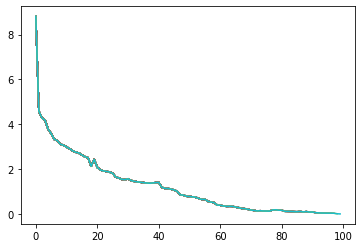

In [16]:
mse = []
pom = 0

for i in range(0, iterations):
    for j in range(ROWS):
        for k in range(COLS):
            for a in ["up", "left", "right", "down"]:
                pom += (all_Q[i][(j,k)][a] - ag.Q_values[(j,k)][a])**2

    mse.append(pom)
    pom = 0
        
    plt.plot(mse)

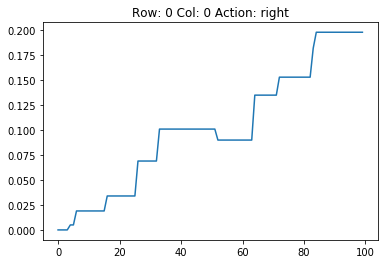

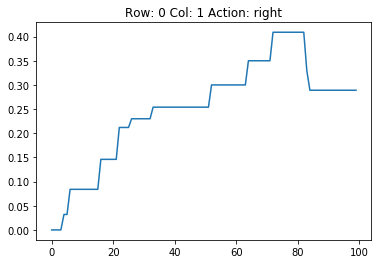

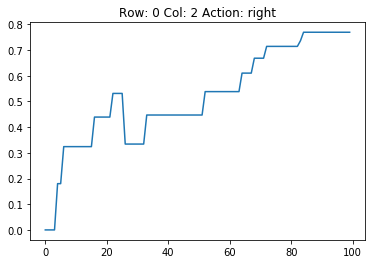

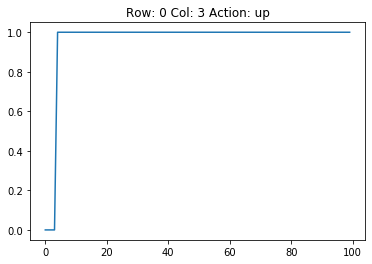

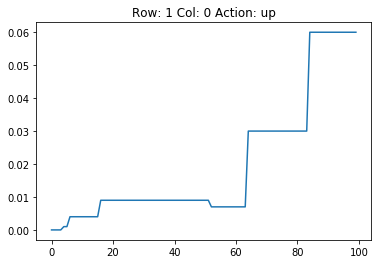

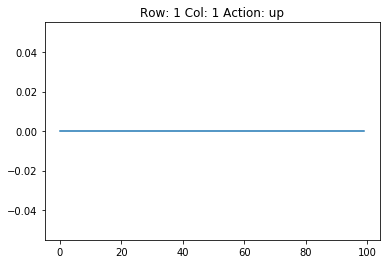

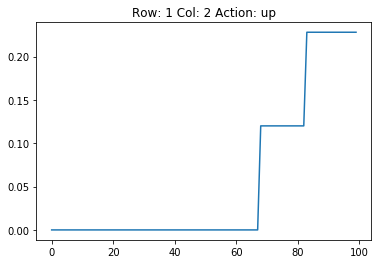

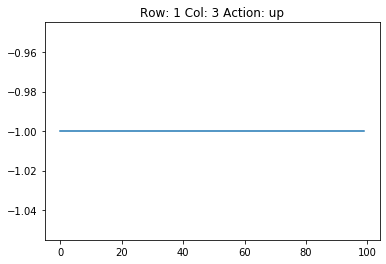

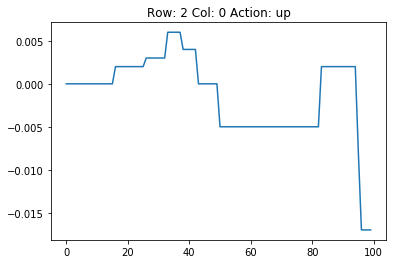

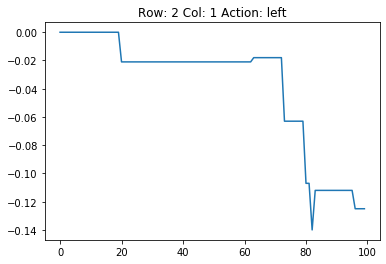

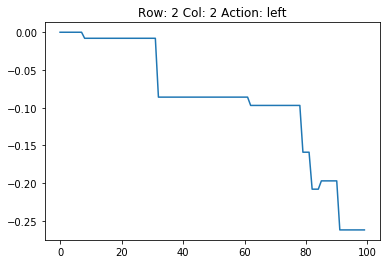

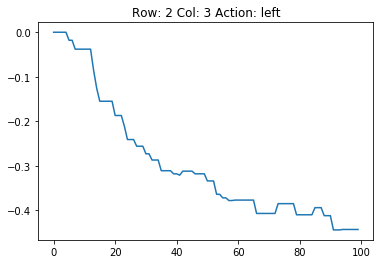

In [19]:
for j in range(ROWS):
    for k in range(COLS):
        pom = []
        #print('row: ', j, 'col: ', k)
        for i in range(0, iterations):
            pom.append(all_Q[i][(j,k)])
        action = max(pom[-1], key=pom[-1].get)
        pom2 = []
        for p in pom:
            pom2.append(p[action])
        #print(action)
        #print(pom2)
        plt.figure()
        plt.plot(pom2)
        plt.title("Row: " + str(j)+" " + "Col: " + str(k) +" "+ "Action: " + action)